In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
import json
import os
import py_vncorenlp
from underthesea import sent_tokenize
import numpy as np
from rank_bm25 import BM25Okapi
from numpy.random import normal
from scipy.stats import truncnorm, boxcox, gamma
import matplotlib.pyplot as plt
import math
import os, sys
sys.path.append("../src")

from sentences_selection import select_sentences
import copy

/home/arch/Projects/college/dsc/dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir=os.path.abspath('../vncorenlp'))

2023-10-27 16:40:21 INFO  WordSegmenter:24 - Loading Word Segmentation model


In [3]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

In [4]:
import re
def no_accent_vietnamese(s):
    s = re.sub(r'[àáạảãâầấậẩẫăằắặẳẵ]', 'a', s)
    s = re.sub(r'[ÀÁẠẢÃĂẰẮẶẲẴÂẦẤẬẨẪ]', 'A', s)
    s = re.sub(r'[èéẹẻẽêềếệểễ]', 'e', s)
    s = re.sub(r'[ÈÉẸẺẼÊỀẾỆỂỄ]', 'E', s)
    s = re.sub(r'[òóọỏõôồốộổỗơờớợởỡ]', 'o', s)
    s = re.sub(r'[ÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠ]', 'O', s)
    s = re.sub(r'[ìíịỉĩ]', 'i', s)
    s = re.sub(r'[ÌÍỊỈĨ]', 'I', s)
    s = re.sub(r'[ùúụủũưừứựửữ]', 'u', s)
    s = re.sub(r'[ƯỪỨỰỬỮÙÚỤỦŨ]', 'U', s)
    s = re.sub(r'[ỳýỵỷỹ]', 'y', s)
    s = re.sub(r'[ỲÝỴỶỸ]', 'Y', s)
    s = re.sub(r'[Đ]', 'D', s)
    s = re.sub(r'[đ]', 'd', s)
    return s

def sentences_splitting(text, rdrsegmenter=rdrsegmenter):

    text_lower = no_accent_vietnamese(text.lower())
    
    original_sents=[]
    processed_sents = []
    
    text_pos = 0
    for _, sent in rdrsegmenter.annotate_text(text).items():
        words = [w["wordForm"] for w in sent]
        words = [w.replace("_", " ") if w != "_" else "_" for w in words]

        processed_sents.append(" ".join(words))

        words = [no_accent_vietnamese(w.lower()) for w in words]
        words = sum([w.split() for w in words],[])


        # find position of words in text_lower
        pos_start = []
        pos_end = []

        for w in words:
            idx = text_lower.find(w,text_pos)

            pos_start.append(idx)
            pos_end.append(idx + len(w))

            text_pos = idx + len(w)
        
        # for testing
        # test = [text_lower[pos_start[i]: pos_end[i]] for i in range(len(pos_start))]
        # assert test == words

        original_sents.append(text[pos_start[0]: pos_end[-1]])
    return original_sents, processed_sents


In [5]:
data = pd.read_json("../datasets/ise-dsc01-public-test-offcial.json", orient="index")

In [6]:
idx = 29706

In [7]:
data.sample(n=1).reset_index().loc[0]

index                                                  46314
context    Sau khi bỏ thịt vì lý do đạo đức, sức khỏe hoặ...
claim      Mèo không phải là động vật ăn thịt bắt buộc nê...
Name: 0, dtype: object

In [834]:
idx = 29706
sample = data.sample(n=1).reset_index().loc[0]
text = sample["context"]
claim = sample["claim"]
context = rdrsegmenter.word_segment(text)

In [835]:
def clean_str(s):
    return ''.join(e.lower() if e.isalnum() else " " for e in s)

In [836]:
query = no_accent_vietnamese(clean_str(claim)).split()
query

['dong',
 'co',
 'cua',
 'ten',
 'lua',
 'javelin',
 'hien',
 'duoc',
 'san',
 'xuat',
 'doc',
 'quyen',
 'boi',
 'cong',
 'ty',
 'aerojet',
 'rocketdyne',
 'con',
 'williams',
 'international',
 'la',
 'cong',
 'ty',
 'duy',
 'nhat',
 'che',
 'tao',
 'dong',
 'co',
 'phan',
 'luc',
 'canh',
 'quat',
 'cho',
 'da',
 'so',
 'cac',
 'loai',
 'ten',
 'lua',
 'hanh',
 'trinh']

In [837]:
[no_accent_vietnamese(clean_str(doc)) for doc in context]

['  chien tranh luon dang so nhung se cang dang so hon khi phe cua ban chua chuan bi day du     seth g  jones   pho chu tich kiem giam doc chuong trinh an ninh quoc te tai trung tam chien luoc va nghien cuu quoc te   csis   o my   viet  ',
 'sau hon mot nam xung dot ukraine   vien tro quan su cua washington cho kiev dat 32 ty usd  ',
 'nhieu he thong vu khi va dan duoc gui toi ukraine   khien kho du tru cua my ngay cang can kiet  ',
 'my da cung cap cho ukraine hon 8 500 ten lua chong tang javelin   1 600 ten lua stinger   38 he thong himars trong giai doan thang 2 2022   3 2023  su ho tro nay rat quan trong voi ukraine trong cuoc chien voi nga   song chi phi ma my bo ra la rat lon  ',
 'toc do quan doi ukraine su dung dan duoc va vu khi da gay cang thang cho nganh cong nghiep quoc phong my  ',
 '  cac goi vien tro nay la quyet dinh dung dan khi chung giup ngan buoc tien cua nga  ',
 'nhung day cung la nhung he thong ma my co the su dung de huan luyen binh si hoac du tru cho xung dot t

In [838]:
bm25 = BM25Okapi([no_accent_vietnamese(clean_str(doc)).split() for doc in context])

In [839]:
query_score = bm25.get_scores(query=query)
query_score

array([ 4.79786634,  5.43948624,  2.34680037,  6.91496834,  5.43844727,
        2.30041565,  1.93930935, 10.23214332, 11.61487357,  5.35556291,
        7.08481761,  4.24374584,  1.3792567 ,  0.88995494, 12.74857379,
        5.81924453,  8.81934346,  9.48242845,  7.46982159,  5.34801941,
        8.42970063,  7.66834878, 59.65651648, 13.48232448,  1.01184546,
        8.53281774,  4.91348361,  2.06826157,  7.09759893])

In [840]:
def distribute_score(score, arr_len, pos):
    if arr_len == 1:
        return [score]
    myclip_a = 0
    myclip_b = 1
    my_mean = pos/(arr_len - 1)
    my_std = 0.65 / arr_len
    
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std

    x_range = np.linspace(0,1,arr_len)

    y = truncnorm.pdf(x_range, a, b, loc = my_mean, scale = my_std)

    return score*y/sum(y)
    

In [841]:
# final_doc_scores = np.zeros(len(query_score))

final_doc_scores = sum([distribute_score(score,len(query_score), idx) for idx, score in enumerate(query_score)])
sorted_ids = sorted(range(len(context)), key=lambda k: final_doc_scores[k], reverse=True)

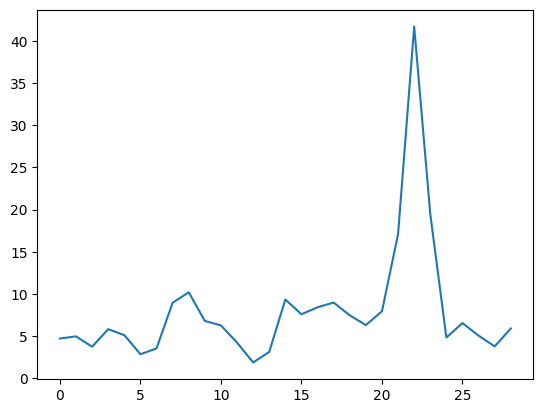

In [842]:
x = range(len(context))

plt.plot(x, final_doc_scores)

In [843]:
claim

'Động cơ của tên lửa Javelin hiện được sản xuất độc quyền bởi công ty Aerojet Rocketdyne còn Williams International là công ty duy nhất chế tạo động cơ phản lực cánh quạt cho đa số các loại tên lửa hành trình'

In [844]:
[context[i] for i in sorted_ids]

['Động_cơ của tên_lửa Javelin hiện được sản_xuất độc_quyền bởi công_ty Aerojet_Rocketdyne , trong khi Williams_International là công_ty duy_nhất chế_tạo động_cơ_phản_lực cánh_quạt cho hầu_hết tên_lửa hành_trình .',
 'Mỹ còn đối_mặt với tình_trạng thiếu_hụt một_số kim_loại đất_hiếm , mà Trung_Quốc gần như là nhà_cung_cấp độc_quyền , vốn rất quan_trọng trong sản_xuất các loại tên_lửa và đạn_dược khác .',
 'Trong một_số trường_hợp , một_số thiết_bị quan_trọng chỉ do một công_ty sản_xuất .',
 'Ngoài_ra , tốc_độ xuất_khẩu một_số loại vũ_khí như Javelin , Stinger , HIMARS , hệ_thống Rocket_Phóng loạt Dẫn đường ( GMLRS ) hay tên_lửa chống hạm Harpoon đồng_nghĩa Mỹ có nguy_cơ không còn đủ kho đạn_dược để đáp_ứng nếu xảy ra xung_đột trong tương_lai .',
 'Giới quan_sát cho rằng trong bối_cảnh cạnh_tranh quốc_tế hiện_nay , Mỹ cần một chiến_lược quốc_gia để củng_cố cơ_sở công_nghiệp quốc_phòng và tăng năng_lực quân_sự .',
 'Tuy_nhiên , trở_ngại là các công_ty này thường không sẵn_sàng tăng mạnh sả

In [845]:
model_max_length = 256
claim_tk_length = len(tokenizer(claim).input_ids[:-1])
abstract_len = model_max_length - claim_tk_length - 1
context_tk_length = [len(tokenizer(s).input_ids[:-1]) for s in context]

In [846]:
fin_len = 0
mask = [0 for _ in range(len(sorted_ids))]
for i in sorted_ids:
    if fin_len + context_tk_length[i] > abstract_len:
        break
    
    fin_len += context_tk_length[i]
    mask[i] = 1

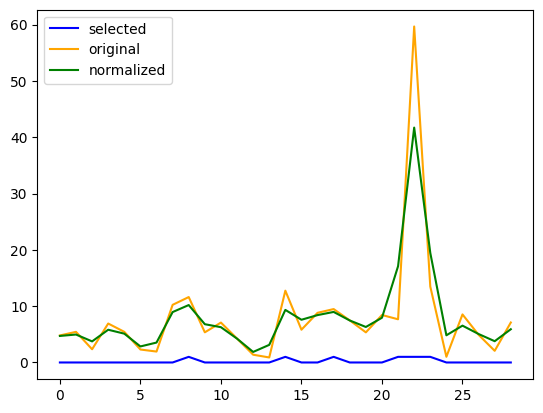

In [847]:
plt.plot(x, mask,color="blue", label="selected")
# original
plt.plot(x, query_score,color="orange",label="original")
# normalized
plt.plot(x, final_doc_scores,color="green", label="normalized")
plt.legend(loc='best')
plt.show()

In [848]:
[context[i] for i in range(len(context)) if mask[i] == 1]

['Ngoài_ra , tốc_độ xuất_khẩu một_số loại vũ_khí như Javelin , Stinger , HIMARS , hệ_thống Rocket_Phóng loạt Dẫn đường ( GMLRS ) hay tên_lửa chống hạm Harpoon đồng_nghĩa Mỹ có nguy_cơ không còn đủ kho đạn_dược để đáp_ứng nếu xảy ra xung_đột trong tương_lai .',
 'Giới quan_sát cho rằng trong bối_cảnh cạnh_tranh quốc_tế hiện_nay , Mỹ cần một chiến_lược quốc_gia để củng_cố cơ_sở công_nghiệp quốc_phòng và tăng năng_lực quân_sự .',
 'Tuy_nhiên , trở_ngại là các công_ty này thường không sẵn_sàng tăng mạnh sản_lượng và chấp_nhận rủi_ro tài_chính mà không có hợp_đồng dài_hạn với chính_phủ .',
 'Trong một_số trường_hợp , một_số thiết_bị quan_trọng chỉ do một công_ty sản_xuất .',
 'Động_cơ của tên_lửa Javelin hiện được sản_xuất độc_quyền bởi công_ty Aerojet_Rocketdyne , trong khi Williams_International là công_ty duy_nhất chế_tạo động_cơ_phản_lực cánh_quạt cho hầu_hết tên_lửa hành_trình .',
 'Mỹ còn đối_mặt với tình_trạng thiếu_hụt một_số kim_loại đất_hiếm , mà Trung_Quốc gần như là nhà_cung_cấp

In [849]:
claim

'Động cơ của tên lửa Javelin hiện được sản xuất độc quyền bởi công ty Aerojet Rocketdyne còn Williams International là công ty duy nhất chế tạo động cơ phản lực cánh quạt cho đa số các loại tên lửa hành trình'

# context slicing
slice a single context into multiple smaller context 

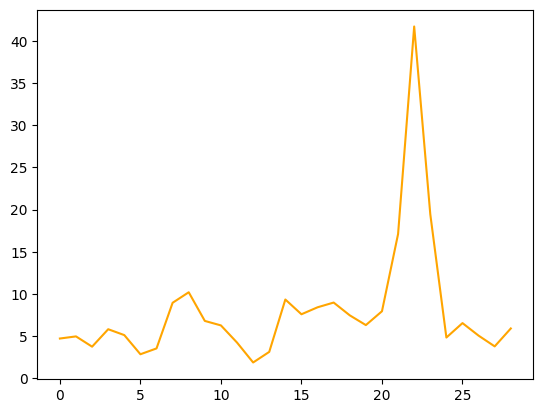

In [850]:
plt.plot(x, final_doc_scores,color="orange",label="original")
plt.show()

In [851]:
context_tk_length


[47,
 19,
 19,
 54,
 17,
 17,
 25,
 30,
 52,
 23,
 21,
 19,
 20,
 28,
 26,
 31,
 18,
 26,
 25,
 34,
 13,
 14,
 35,
 31,
 10,
 12,
 34,
 31,
 23]

In [852]:
def get_longest_continuest_context(tokenized_sents_lenght, start_pos, max_token_number):
    if start_pos >= len(tokenized_sents_lenght):
        return [], 0
    selected = []
    curr_length = 0
    for idx in range(start_pos, len(tokenized_sents_lenght)):
        if curr_length + tokenized_sents_lenght[idx] > max_token_number:
            break
        selected.append(idx)
        curr_length += tokenized_sents_lenght[idx]
    
    return selected, curr_length

In [853]:
def get_best_continuest_context(tokenized_sents_lenght, query_score, max_token_number=200):
    best_context = []
    max_score = 0
    for i in range(len(tokenized_sents_lenght)):
        selected, curr_length = get_longest_continuest_context(tokenized_sents_lenght, start_pos=i, max_token_number=max_token_number)
        score = sum([query_score[i] for i in selected])
        if score > max_score:
            best_context = selected
            max_score = score
    return best_context, max_score

In [854]:
best_context, max_score = get_best_continuest_context(
    tokenized_sents_lenght=context_tk_length,
    query_score=final_doc_scores
)

print([context[i] for i in best_context])

['Tuy_nhiên , trở_ngại là các công_ty này thường không sẵn_sàng tăng mạnh sản_lượng và chấp_nhận rủi_ro tài_chính mà không có hợp_đồng dài_hạn với chính_phủ .', 'Dù Bộ Quốc_phòng Mỹ thường ký hợp_đồng nhiều năm cho tàu và máy_bay , họ không ký hợp_đồng dài_hạn với nhiều loại đạn_dược .', 'Ngoài_ra , Mỹ thường_xuyên cắt_giảm ngân_sách đạn_dược vào cuối mỗi năm tài_khoá để nhường chỗ cho các ưu_tiên khác hoặc để khắc_phục các vấn_đề phát_sinh trong quá_trình mua_sắm các loại vũ_khí lớn .', 'Những hạn_chế về lực_lượng lao_động và chuỗi cung_ứng cũng là trở_ngại .', 'Trong một_số trường_hợp , một_số thiết_bị quan_trọng chỉ do một công_ty sản_xuất .', 'Động_cơ của tên_lửa Javelin hiện được sản_xuất độc_quyền bởi công_ty Aerojet_Rocketdyne , trong khi Williams_International là công_ty duy_nhất chế_tạo động_cơ_phản_lực cánh_quạt cho hầu_hết tên_lửa hành_trình .', 'Mỹ còn đối_mặt với tình_trạng thiếu_hụt một_số kim_loại đất_hiếm , mà Trung_Quốc gần như là nhà_cung_cấp độc_quyền , vốn rất quan_

In [855]:
def slice_context(tokenized_sents_lenght, number_of_contexts, query_score, max_token_number=200):
    qscores = copy.copy(query_score)
    selected = []

    for _ in range(number_of_contexts*2):
        if len(selected) >= number_of_contexts:
            break
        best_context, max_score = get_best_continuest_context(
            tokenized_sents_lenght=context_tk_length,
            query_score=qscores,
            max_token_number=max_token_number
        )
        
        # reduce the score of the selected context

        for i in best_context:
            qscores[i] /= 3.5
        print(max_score)
        if best_context not in selected:
            selected.append(best_context)
    return selected

In [856]:
MODEL_MAX_TOKEN = 500

In [857]:
math.ceil(sum(context_tk_length)*1.25/MODEL_MAX_TOKEN)

2

In [858]:
res = slice_context(
    tokenized_sents_lenght=context_tk_length,
    number_of_contexts = math.ceil(sum(context_tk_length)*1.2/MODEL_MAX_TOKEN),
    query_score=final_doc_scores,
    max_token_number=MODEL_MAX_TOKEN
)
res

190.59940761583013
62.712729503961405


[[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
 [9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28]]

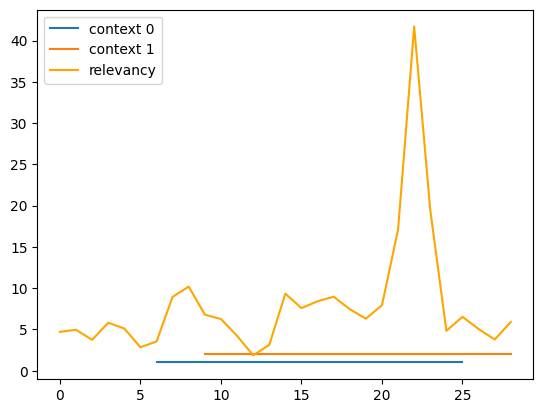

In [859]:

for idx,sl in enumerate(res):
    plt.plot(sl, [1 + idx for _ in range(len(sl))], label="context " + str(idx))
plt.plot(x, final_doc_scores,color="orange",label="relevancy")
plt.legend(loc='best')

plt.show()


In [860]:
sum(context_tk_length)

754

In [861]:
claim

'Động cơ của tên lửa Javelin hiện được sản xuất độc quyền bởi công ty Aerojet Rocketdyne còn Williams International là công ty duy nhất chế tạo động cơ phản lực cánh quạt cho đa số các loại tên lửa hành trình'

In [862]:
[[context[i] for i in sl] for sl in res]

[['Nhưng đây cũng là những hệ_thống mà Mỹ có_thể sử_dụng để huấn_luyện binh_sĩ hoặc dự_trữ cho xung_đột tương_lai " , ông Jones nói .',
  'Ngay cả khi tăng tốc_độ sản_xuất , Mỹ có_thể mất vài năm để bù_đắp số tên_lửa Javelin , Stinger và các loại vũ_khí khác đã chuyển sang Ukraine .',
  'Ngoài_ra , tốc_độ xuất_khẩu một_số loại vũ_khí như Javelin , Stinger , HIMARS , hệ_thống Rocket_Phóng loạt Dẫn đường ( GMLRS ) hay tên_lửa chống hạm Harpoon đồng_nghĩa Mỹ có nguy_cơ không còn đủ kho đạn_dược để đáp_ứng nếu xảy ra xung_đột trong tương_lai .',
  '" Xung_đột ở Ukraine đã chứng_minh rằng cuộc_chiến tiêu_hao thực_chất sẽ là xung_đột của các nền công_nghiệp " , Jones nhận_xét .',
  'Nỗ_lực triển_khai , trang_bị và tiếp_tế cho các lực_lượng là nhiệm_vụ đòi_hỏi phải có một cơ_sở công_nghiệp quy_mô lớn .',
  'Trong một_số ngày , quân_đội Nga đã phóng 50.000 quả đạn pháo vào các vị_trí của Ukraine .',
  'Lượng đạn pháo 155 mm Ukraine bắn trong 5 ngày bằng số_lượng đạn Mỹ sản_xuất trong một tháng